# AI-Powered Phishing Email Detection System

## Introduction
Phishing attacks are among the most prevalent forms of cyber threats, often relying on deceptive emails to trick recipients into revealing sensitive information or clicking malicious links. Traditional rule-based systems for phishing detection struggle to adapt to the rapidly evolving language and structure of phishing emails. As a result, artificial intelligence (AI) methods—particularly machine learning—have become essential tools for building more flexible and accurate detection systems.

In this project, we develop an AI-powered phishing email detection system that classifies emails as phishing or legitimate using natural language features and metadata. Our focus is on building a lightweight, interpretable prototype using the XGBoost classifier, a gradient boosting algorithm known for its performance and efficiency.

We use a publicly available dataset from Kaggle that includes both phishing and legitimate emails with labeled examples. You can access the dataset here:

[🔗 Phishing Email Dataset on Kaggle](https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset)

The project involves the following core components:
*   Data cleaning and feature extraction from email content.
*   Training and evaluation of an XGBoost classification model.
*   Applying explainability techniques (e.g., SHAP) to interpret model predictions.
*   Testing the model on real-world-like examples and documenting its strengths and limitations.

The goal is to create a simple, explainable, and effective prototype that could form the basis of a real-world email threat detection tool.

## Step 1: Environment set up

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier

## Step 2: Dataset Exploration

In [42]:
# Where 'text_combined' contains the text data and 'label' is 1 for phishing, 0 for legitimate

df = pd.read_csv('../dataset/phishing_email.csv')

# Check the dataset
print(df.head())
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['label'].value_counts()}")

                                       text_combined  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0
Dataset shape: (82486, 2)
Class distribution:
label
1    42891
0    39595
Name: count, dtype: int64


## Step 3: Split the data into training and testing sets

In [43]:
# 1. Split into 80% train_val and 20% test
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df["text_combined"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# 2. Split train_val into 70% train and 10% validation (from total data)
X_train, X_val, y_train, y_val = train_test_split(
    train_val_texts, train_val_labels, test_size=0.125, random_state=42, stratify=train_val_labels
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(test_texts)}")

Train size: 57739
Validation size: 8249
Test size: 16498


## Define Pipeline

In [44]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        verbosity=1  # Verbose during model training
    ))
])

In [73]:
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5],
    'xgb__learning_rate': [0.1, 0.3]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits


KeyboardInterrupt: 

## Evaluate on validation set

In [ ]:
val_preds = grid.predict(X_val)
print("\nValidation performance:")
print(classification_report(y_val, val_preds))


Validation performance:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3960
           1       0.98      0.99      0.98      4289

    accuracy                           0.98      8249
   macro avg       0.98      0.98      0.98      8249
weighted avg       0.98      0.98      0.98      8249



## Retrain best model on full train+val

In [1]:
final_model = grid.best_estimator_
final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

NameError: name 'grid' is not defined

## Evaluate on test set

In [ ]:
test_preds = final_model.predict(test_texts)
test_probs = final_model.predict_proba(test_texts)[:, 1]  # For AUC

## Evaluation Metrics


Final Test Results:
Accuracy: 98.41%
Precision: 97.76%
Recall: 99.22%
F1-score: 98.48%
AUC-ROC: 99.87%


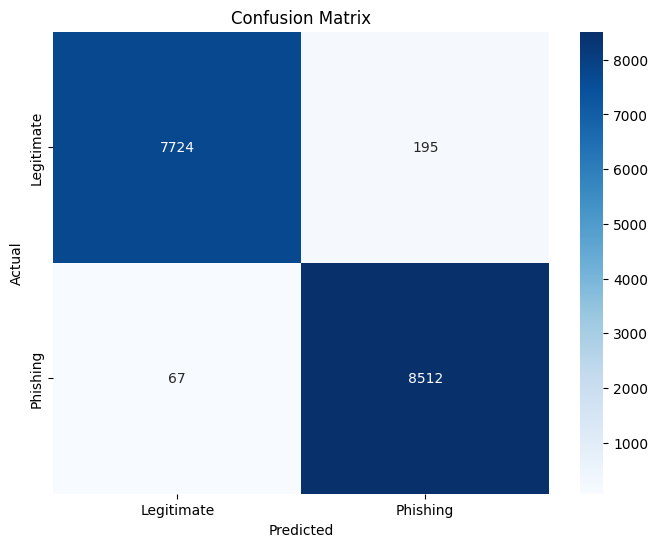


Confusion Matrix Details:
True Negatives: 7724 (Legitimate emails correctly identified)
False Positives: 195 (Legitimate emails incorrectly flagged as phishing)
False Negatives: 67 (Phishing emails missed)
True Positives: 8512 (Phishing emails correctly identified)


In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

accuracy = accuracy_score(test_labels, test_preds) * 100
precision = precision_score(test_labels, test_preds, pos_label=df['label'].unique()[1]) * 100
recall = recall_score(test_labels, test_preds, pos_label=df['label'].unique()[1]) * 100
f1 = f1_score(test_labels, test_preds, pos_label=df['label'].unique()[1]) * 100
auc = roc_auc_score(test_labels, test_probs) * 100

import matplotlib.pyplot as plt

print("\nFinal Test Results:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-score: {f1:.2f}%")
print(f"AUC-ROC: {auc:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
      xticklabels=['Legitimate', 'Phishing'],
      yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print confusion matrix metrics
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Details:")
print(f"True Negatives: {tn} (Legitimate emails correctly identified)")
print(f"False Positives: {fp} (Legitimate emails incorrectly flagged as phishing)")
print(f"False Negatives: {fn} (Phishing emails missed)")
print(f"True Positives: {tp} (Phishing emails correctly identified)")

# Export the model

In [ ]:
import pickle
import os
import pickle

# Create a directory for the model if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the final model
with open("models/phishing_detection_model.pkl", "wb") as f:
  pickle.dump(final_model, f)

print("Model successfully exported to 'models/phishing_detection_model.pkl'")

# Optional: Save the feature importance information
importance_df.to_csv("models/feature_importance.csv", index=False)
print("Feature importance exported to 'models/feature_importance.csv'")

# Example of how to load the model
print("\nExample code to load the model:")
print("""

# Load the model
with open("models/phishing_detection_model.pkl", "rb") as f:
  loaded_model = pickle.load(f)

# Example prediction
# prediction = loaded_model.predict(['Your email text here'])
""")

Model successfully exported to 'models/phishing_detection_model.pkl'
Feature importance exported to 'models/feature_importance.csv'

Example code to load the model:


# Load the model
with open("models/phishing_detection_model.pkl", "rb") as f:
  loaded_model = pickle.load(f)

# Example prediction
# prediction = loaded_model.predict(['Your email text here'])



In [ ]:
import pickle
import pandas as pd
import numpy as np

# Load the saved model
with open("models/phishing_detection_model.pkl", "rb") as f:
  loaded_model = pickle.load(f)

# Create some test examples
test_emails = [
  "Dear customer, your account has been locked. Please click here to verify your identity: http://suspicious-link.com",
  "Meeting agenda for tomorrow: 1. Project updates 2. Budget review 3. New hires",
  "Congratulations! You've won $1,000,000 in our lottery. To claim your prize, send your bank details to claim@scam-lottery.com"
]

# Make predictions
predictions = loaded_model.predict(test_emails)
probabilities = loaded_model.predict_proba(test_emails)[:, 1]  # Probability of being phishing

# Display results
results = pd.DataFrame({
  'Email': test_emails,
  'Is Phishing': predictions,
  'Phishing Probability': probabilities
})

print("Model predictions:")
for i, (email, pred, prob) in enumerate(zip(test_emails, predictions, probabilities)):
  print(f"\nEmail {i+1}: {email[:50]}...")
  print(f"Prediction: {'Phishing' if pred == 1 else 'Legitimate'}")
  print(f"Confidence: {prob:.2%}")

Model predictions:

Email 1: Dear customer, your account has been locked. Pleas...
Prediction: Phishing
Confidence: 97.39%

Email 2: Meeting agenda for tomorrow: 1. Project updates 2....
Prediction: Legitimate
Confidence: 10.50%

Email 3: Congratulations! You've won $1,000,000 in our lott...
Prediction: Phishing
Confidence: 70.44%
